# <center>Structural bottlenecks</center>

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, <a href="https://twitter.com/guerrero_oa">@guerrero_oa</a>)

The previous tutorial explained how to simulate a budgetary intervention, and the results suggest that, for this example, the indicators respond modestly to lnear increments in government expenditure. In this tutorial, I will explain how to expand on the idea of expenditure sensitivity in order to quantify structural bottlenecks, a concept that is often discussed in the development economics and SDG literature, but that is rarely formalised. In addition, I will show you how to perform a larger set of Monte Carlo simulations while disributing their work load across multiple cores or processors.

## Importing Python libraries to manipulate and visualise data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing PPI functions

In [2]:
import requests
url = 'https://raw.githubusercontent.com/oguerrer/ppi/main/source_code/ppi.py'
r = requests.get(url)
with open('ppi.py', 'w') as f:
    f.write(r.text)
import ppi

## Load data

In [6]:
# INDICATORS
df_indis = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/data_indicators.csv')
N = len(df_indis) # number of indicators
I0 = df_indis.IF.values # initial values
R = df_indis.instrumental # instrumental indicators
qm = df_indis.qm.values # quality of monitoring
rl = df_indis.rl.values # quality of the rule of law
indis_index = dict([(code, i) for i, code in enumerate(df_indis.seriesCode)]) # used to build the network matrix
Imax = df_indis.maxVals.values
Imin = df_indis.minVals.values
goals = np.random.rand(N)*(Imax - I0) + I0

# PARAMETERS
df_params = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/parameters.csv')
alphas = df_params.alpha.values
alphas_prime = df_params.alpha_prime.values
betas = df_params.beta.values

# NETWORK
df_net = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/data_network.csv')
A = np.zeros((N, N)) # adjacency matrix
for index, row in df_net.iterrows():
    i = indis_index[row.origin]
    j = indis_index[row.destination]
    w = row.weight
    A[i,j] = w

# DISBURSEMENT SCHEDULE (make sure that the disbursement schedule is consistent with T, otherwise PPI will simulate the T of the calibration)
T = 30
df_exp = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/data_expenditure.csv')
Bs_retrospective = df_exp.values[:,1::] # disbursement schedule (assumes that the expenditure programmes are properly sorted)
# Create a new disbursement schedule assuming that expenditure will be the same as the last period of the sample
Bs = np.tile(Bs_retrospective[:,-1], (T,1)).T

# RELATIONAL TABLE
df_rela = pd.read_csv('https://raw.githubusercontent.com/oguerrer/ppi/main/tutorials/clean_data/data_relational_table.csv')
B_dict = {}
for index, row in df_rela.iterrows():
    B_dict[indis_index[row.seriesCode]] = [programme for programme in row.values[1::][row.values[1::].astype(str)!='nan']]

## Bottlenecks

In the book, we develop two definitions of structural bottlenecks:

1. Idiosyncratic bottlenecks: Those that focus on the structural constraints of a single indicator.
2. Systemic bottlenecks: Those that "clog" the development of other policy issues through indirect impacts.

In this tutorial, I will focus on the first type: <strong>idiosyncratic bottlenecks</strong>. An idiosyncratic bottleneck bottleneck manifests when a–historically poor-performing indicator–responds poorly to budgetary interventions. An indicator may not respond to an expenditure programme because it experiences strong structural constraints (e.g., badly designed policies) that can only be lifted through long-term structural reforms (e.g., redesigning the relevant government programmes), not just by spending more resources. Alternatively, a particular network structure may also be responsible for a poor response if other development dimensions exert a negative influence on the indicator.

Regardless of the reason behind a poor response, a necessary condition to identify an indicator with an idiosyncratic bottleneck is a historically bad performance. This is so because and indicator could be insensitive to budget interventions due to decreasing marginal returns, as opposed to ill-concieved programmes.


### The budgetary frontier

To identify an idiosyncratric bottleneck you need to think of a hypothetical budgetary intervention that would lift all financial obstacles and negative spillovers. Effectively, such scenario would mean that the probability of success of the intervened indicator is always 1. This hypothetical scenario is called the <strong>budgetary frontier</strong>, and was originally developed in https://doi.org/10.1007/s11625-022-01095-1. The idea is that, if a government operates on the budgetary frontier, and there are still indicators that respond poorly, it means that they are being constrained by long-term structural factors.

To perform frontier analysis, the `run_ppi` function offers the optional parameter `frontier`. This parameter consists of a vector specifying the probability of success that one would like to exogenously impose to each indicator. Hence, for this tutorial, I will impose a value of 1 for all indicators.


### Parallelisation

Instead of calling the `run_ppi` function in an explicit `for` loop, I will use `run_ppi_parallel`, which allows to perform multiple Monte Carlo simulations and distribute their load across four cores or processors. This functions takes the same inputs as `run_ppi` with a couple of additional ones to specify the number of simulations. First, I will run the baseline simulation and, then, the frontier one.

In [29]:
parallel_processes=4
sample_size=1000 # now we increase the sample size to 1000

# first the baseline
outputs_baseline = ppi.run_ppi_parallel(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                                        Imax=Imax, Imin=Imin, Bs=Bs, B_dict=B_dict, T=T, G=goals,
                                        parallel_processes=parallel_processes, sample_size=sample_size)

# now the frontier
# notice that Bs and B_dict will be overridden by frontier
frontier = 1
outputs_frontier = ppi.run_ppi_parallel(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                                        Imax=Imax, Imin=Imin, Bs=Bs, B_dict=B_dict, T=T, G=goals, frontier=frontier,
                                        parallel_processes=parallel_processes, sample_size=sample_size)

Now we unpack the outputs and obtain the average time series of the baseliene and the counterfactual.

In [20]:
tsI_sample, tsC_sample, tsF_sample, tsP_sample, tsS_sample, tsG_sample = outputs_baseline
tsI_baseline = np.mean(tsI_sample, axis=0)

tsI_sample, tsC_sample, tsF_sample, tsP_sample, tsS_sample, tsG_sample = outputs_frontier
tsI_frontier = np.mean(tsI_sample, axis=0)

Time to visualise the difference in gaps.

In [27]:
tsI_baseline[index,T-1], tsI_frontier[index,T-1]

(0.6129739012806091, 0.6149664614532312)

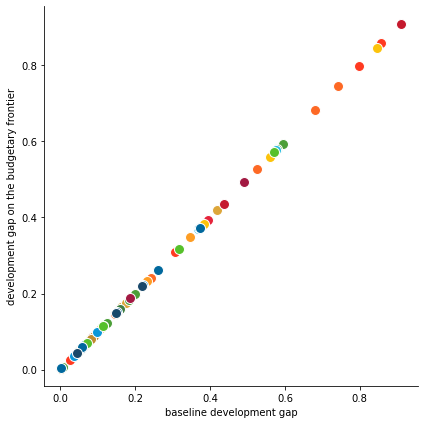

In [28]:
plt.figure(figsize=(6, 6))
for index, row in df_indis.iterrows():
    goal = goals[index]
    if goal > tsI_baseline[index,T-1]:
        plt.plot(goal-tsI_baseline[index,T-1], goal-tsI_frontier[index,T-1],
                 '.', mec='w', mfc=row.color, markersize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('baseline development gap')
plt.ylabel('development gap on the budgetary frontier')
plt.tight_layout()